# ***Data Science Project: Activity prediction for chemical compounds*** 

**ID2214 Team 13**

- Christian Durán García - chdg@kth.se
- Kailin Wu - kailinw@kth.se

### Declaration
By submitting this solution, it is hereby declared that all individuals listed above have contributed to the solution, either with code that appear in the final solution below, or with code that has been evaluated and compared to the final solution, but for some reason has been excluded. It is also declared that all project members fully understand all parts of the final solution and can explain it upon request.

It is furthermore declared that the code below is a contribution by the project members only, and specifically that no part of the solution has been copied from any other source (except for lecture slides at the course ID2214/FID3214) and no part of the solution has been provided by someone not listed as project member above.

In [50]:
# Importing preliminary libraries for data exploration and manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## **Data Collection**

In [3]:
# Reading data into dataframes
train_df = pd.read_csv('training_smiles.csv')
test_df = pd.read_csv('test_smiles.csv')

# Display the dataframes
display(train_df.head())
display(test_df.head())

,INDEX,SMILES,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,0.0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,0.0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,0.0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,0.0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,0.0


,INDEX,SMILES
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12


### *Extracting Features*

In [27]:
# Importing rdkit and using it to get all possible features from SMILES strings
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

### Extracting Features from SMILES

def get_descriptors(smiles):
    # Get mol
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: # if none existent then None
        return None
    
    # Names of important descriptors
    descriptor_names = [
        "GetNumAtoms",
        "GetNumHeavyAtoms",
        "NumHAcceptors",
        "NumHDonors",
        "MolLogP",
        "RingCount",
        "NumRotatableBonds",
        "NumValenceElectrons",
        "FractionCSP3",
        "Chi3n",
        "NumAromaticRings",
        "NumAliphaticRings",
        "NumSaturatedRings",
        "NumHeteroatoms",
        "FpDensityMorgan1",
        "BalabanJ",
        "HallKierAlpha",
        "Ipc",
        "LabuteASA",
        "PEOE_VSA10"
    ]

    # Calculate the descriptors using the mol object (Get...)
    descriptors = [getattr(mol, desc)() for desc in descriptor_names if 'Get' in desc]
    # Combine the mol descriptors with the Descriptors library descriptions (~Get...)
    descriptors = descriptors + [getattr(Descriptors, desc)(mol) for desc in descriptor_names if 'Get' not in desc]

    # Combine descriptor names and values into a dictionary
    descriptor_dict = dict(zip(descriptor_names, descriptors))

    return descriptor_dict

def get_SMILES_features(df, dataset):
    # Generate a list of all the dictionaries with all the descriptors for that SMILES text
    features = [get_descriptors(smiles) for smiles in df['SMILES']]

    # Create a dataframe with all the features
    features_df = pd.DataFrame(features)
    
    # Concatenate the features to the existing dataframe
    merged_df = pd.merge(df, features_df, left_index=True, right_index=True, how='inner')

    # Rearrange the order of the columns for the new dataframe
    if dataset == 'training':
        merged_df = merged_df[['INDEX', 'SMILES'] + features_df.columns.tolist() + ['ACTIVE']]
    elif dataset == 'testing':
        merged_df = merged_df[['INDEX', 'SMILES'] + features_df.columns.tolist()]

    return merged_df

#get_SMILES_features(train_df).to_csv('training_features_smiles.csv', dataset='training')
#get_SMILES_features(test_df, dataset='testing').to_csv('testing_features_smiles.csv')

[16:01:06] WARNING: not removing hydrogen atom without neighbors


In [33]:
# Reading datasets with features
train_df = pd.read_csv('training_features_smiles.csv').drop('Unnamed: 0', axis=1)
test_df = pd.read_csv('testing_features_smiles.csv').drop('Unnamed: 0', axis=1)

display(train_df.head())
display(test_df.head())

,INDEX,SMILES,GetNumAtoms,GetNumHeavyAtoms,NumHAcceptors,NumHDonors,MolLogP,RingCount,NumRotatableBonds,NumValenceElectrons,FractionCSP3,Chi3n,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,FpDensityMorgan1,BalabanJ,HallKierAlpha,Ipc,LabuteASA,PEOE_VSA10,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,16,16,3,1,3.65322,2,3,84,0.307692,2.515951,2,0,0,3,1.250000,2.417793,-1.35,5.884579e+03,100.148168,0.000000,0.0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,26,26,6,1,2.11534,3,6,136,0.368421,4.456015,3,0,0,7,1.230769,1.901895,-2.96,9.077380e+05,151.219106,18.258301,0.0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,26,26,4,1,1.28210,3,6,148,0.833333,5.577716,0,3,2,8,1.115385,1.407653,-0.96,9.464246e+05,156.476921,0.000000,0.0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,27,27,5,2,5.30108,3,5,134,0.000000,3.646410,3,0,0,8,1.185185,1.840249,-3.27,1.488488e+06,163.785821,17.326601,0.0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,20,20,2,1,3.46004,2,4,104,0.187500,2.693110,2,0,0,4,1.100000,1.899530,-2.36,2.905101e+04,116.938731,11.566733,0.0


,INDEX,SMILES,GetNumAtoms,GetNumHeavyAtoms,NumHAcceptors,NumHDonors,MolLogP,RingCount,NumRotatableBonds,NumValenceElectrons,FractionCSP3,Chi3n,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,FpDensityMorgan1,BalabanJ,HallKierAlpha,Ipc,LabuteASA,PEOE_VSA10
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1,23,23,3,1,4.00370,3,4,114,0.000000,3.259684,3,0,0,5,1.043478,1.767396,-2.66,3.009279e+05,142.138998,0.000000
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...,34,34,11,2,2.11320,4,9,174,0.142857,4.434457,4,0,0,13,1.147059,1.522320,-4.81,7.014580e+07,191.668429,29.617054
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C,14,14,2,0,3.55344,2,0,72,0.200000,2.198342,2,0,0,4,0.857143,2.831879,-0.86,1.519234e+03,91.888780,0.000000
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1,23,23,6,2,0.77660,3,3,120,0.285714,3.593432,1,2,2,9,1.304348,2.018979,-2.52,2.109546e+05,136.796056,5.697039
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12,28,28,7,2,3.73990,4,4,138,0.095238,4.450477,3,1,0,7,1.071429,1.489357,-4.05,3.814376e+06,159.752545,23.046320


## **EDA**

In [35]:
# Get descriptive statistics based on classes
train_df.drop('INDEX', axis=1).groupby('ACTIVE').describe()

GetNumAtoms                                                     \
             count       mean       std  min   25%   50%   75%    max   
ACTIVE                                                                  
0.0       151446.0  24.403253  5.714640  2.0  21.0  24.0  28.0  117.0   
1.0         1784.0  25.334081  6.406359  7.0  21.0  25.0  29.0   93.0   

       GetNumHeavyAtoms                                                     \
                  count       mean       std  min   25%   50%   75%    max   
ACTIVE                                                                       
0.0            151446.0  24.403246  5.714639  2.0  21.0  24.0  28.0  117.0   
1.0              1784.0  25.334081  6.406359  7.0  21.0  25.0  29.0   93.0   

       NumHAcceptors                                               NumHDonors  \
               count      mean       std  min  25%  50%  75%   max      count   
ACTIVE                                                                          
0.0         151446.0  4.886719  1.889926  0.0  4.0  5.0  6.0  50.0   151446.0   
1.0           1784.0  4.895740  2.186304  0.0  3.0  5.0  6.0  26.0     1784.0   

                                                       MolLogP            \
            mean       std  min  25%  50%  75%   max     count      mean   
ACTIVE                                                                     
0.0     1.139442  0.906997  0.0  1.0  1.0  2.0  24.0  151446.0  2.895087   
1.0     1.106502  1.094463  0.0  0.0  1.0  2.0  16.0    1784.0  3.442377   

                                                                RingCount  \
             std      min       25%     50%       75%       max     count   
ACTIVE                                                                      
0.0     1.276034 -18.5803  2.112725  2.9349  3.725915  16.42850  151446.0   
1.0     1.368457  -3.1680  2.637570  3.5048  4.314455  13.74388    1784.0   

                                                     NumRotatableBonds  \
            mean       std  min  25%  50%  75%   max             count   
ACTIVE                                                                   
0.0     2.947420  1.048421  0.0  2.0  3.0  4.0  21.0          151446.0   
1.0     3.267377  1.122218  0.0  3.0  3.0  4.0  12.0            1784.0   

                                                     NumValenceElectrons  \
            mean       std  min  25%  50%  75%   max               count   
ACTIVE                                                                     
0.0     4.795663  2.348628  0.0  3.0  5.0  6.0  47.0            151446.0   
1.0     4.501682  2.428795  0.0  3.0  4.0  6.0  32.0              1784.0   

                                                               FractionCSP3  \
              mean       std   min    25%    50%    75%    max        count   
ACTIVE                                                                        
0.0     127.579619  30.02583   8.0  108.0  126.0  146.0  670.0     151446.0   
1.0     130.925448  34.28099  30.0  110.0  128.0  148.0  496.0       1784.0   

                                                                       Chi3n  \
            mean       std  min       25%       50%       75%  max     count   
ACTIVE                                                                         
0.0     0.297184  0.181927  0.0  0.166667  0.277778  0.409091  1.0  151446.0   
1.0     0.244478  0.171429  0.0  0.117647  0.222222  0.333333  1.0    1784.0   

                                                                               \
            mean       std       min       25%       50%       75%        max   
ACTIVE                                                                          
0.0     3.970006  1.306913  0.000000  3.056914  3.846242  4.748549  23.478847   
1.0     4.171308  1.529006  0.842825  3.217335  4.009164  4.875774  18.035195   

       NumAromaticRings                                                \
                  count      mean       std  min 

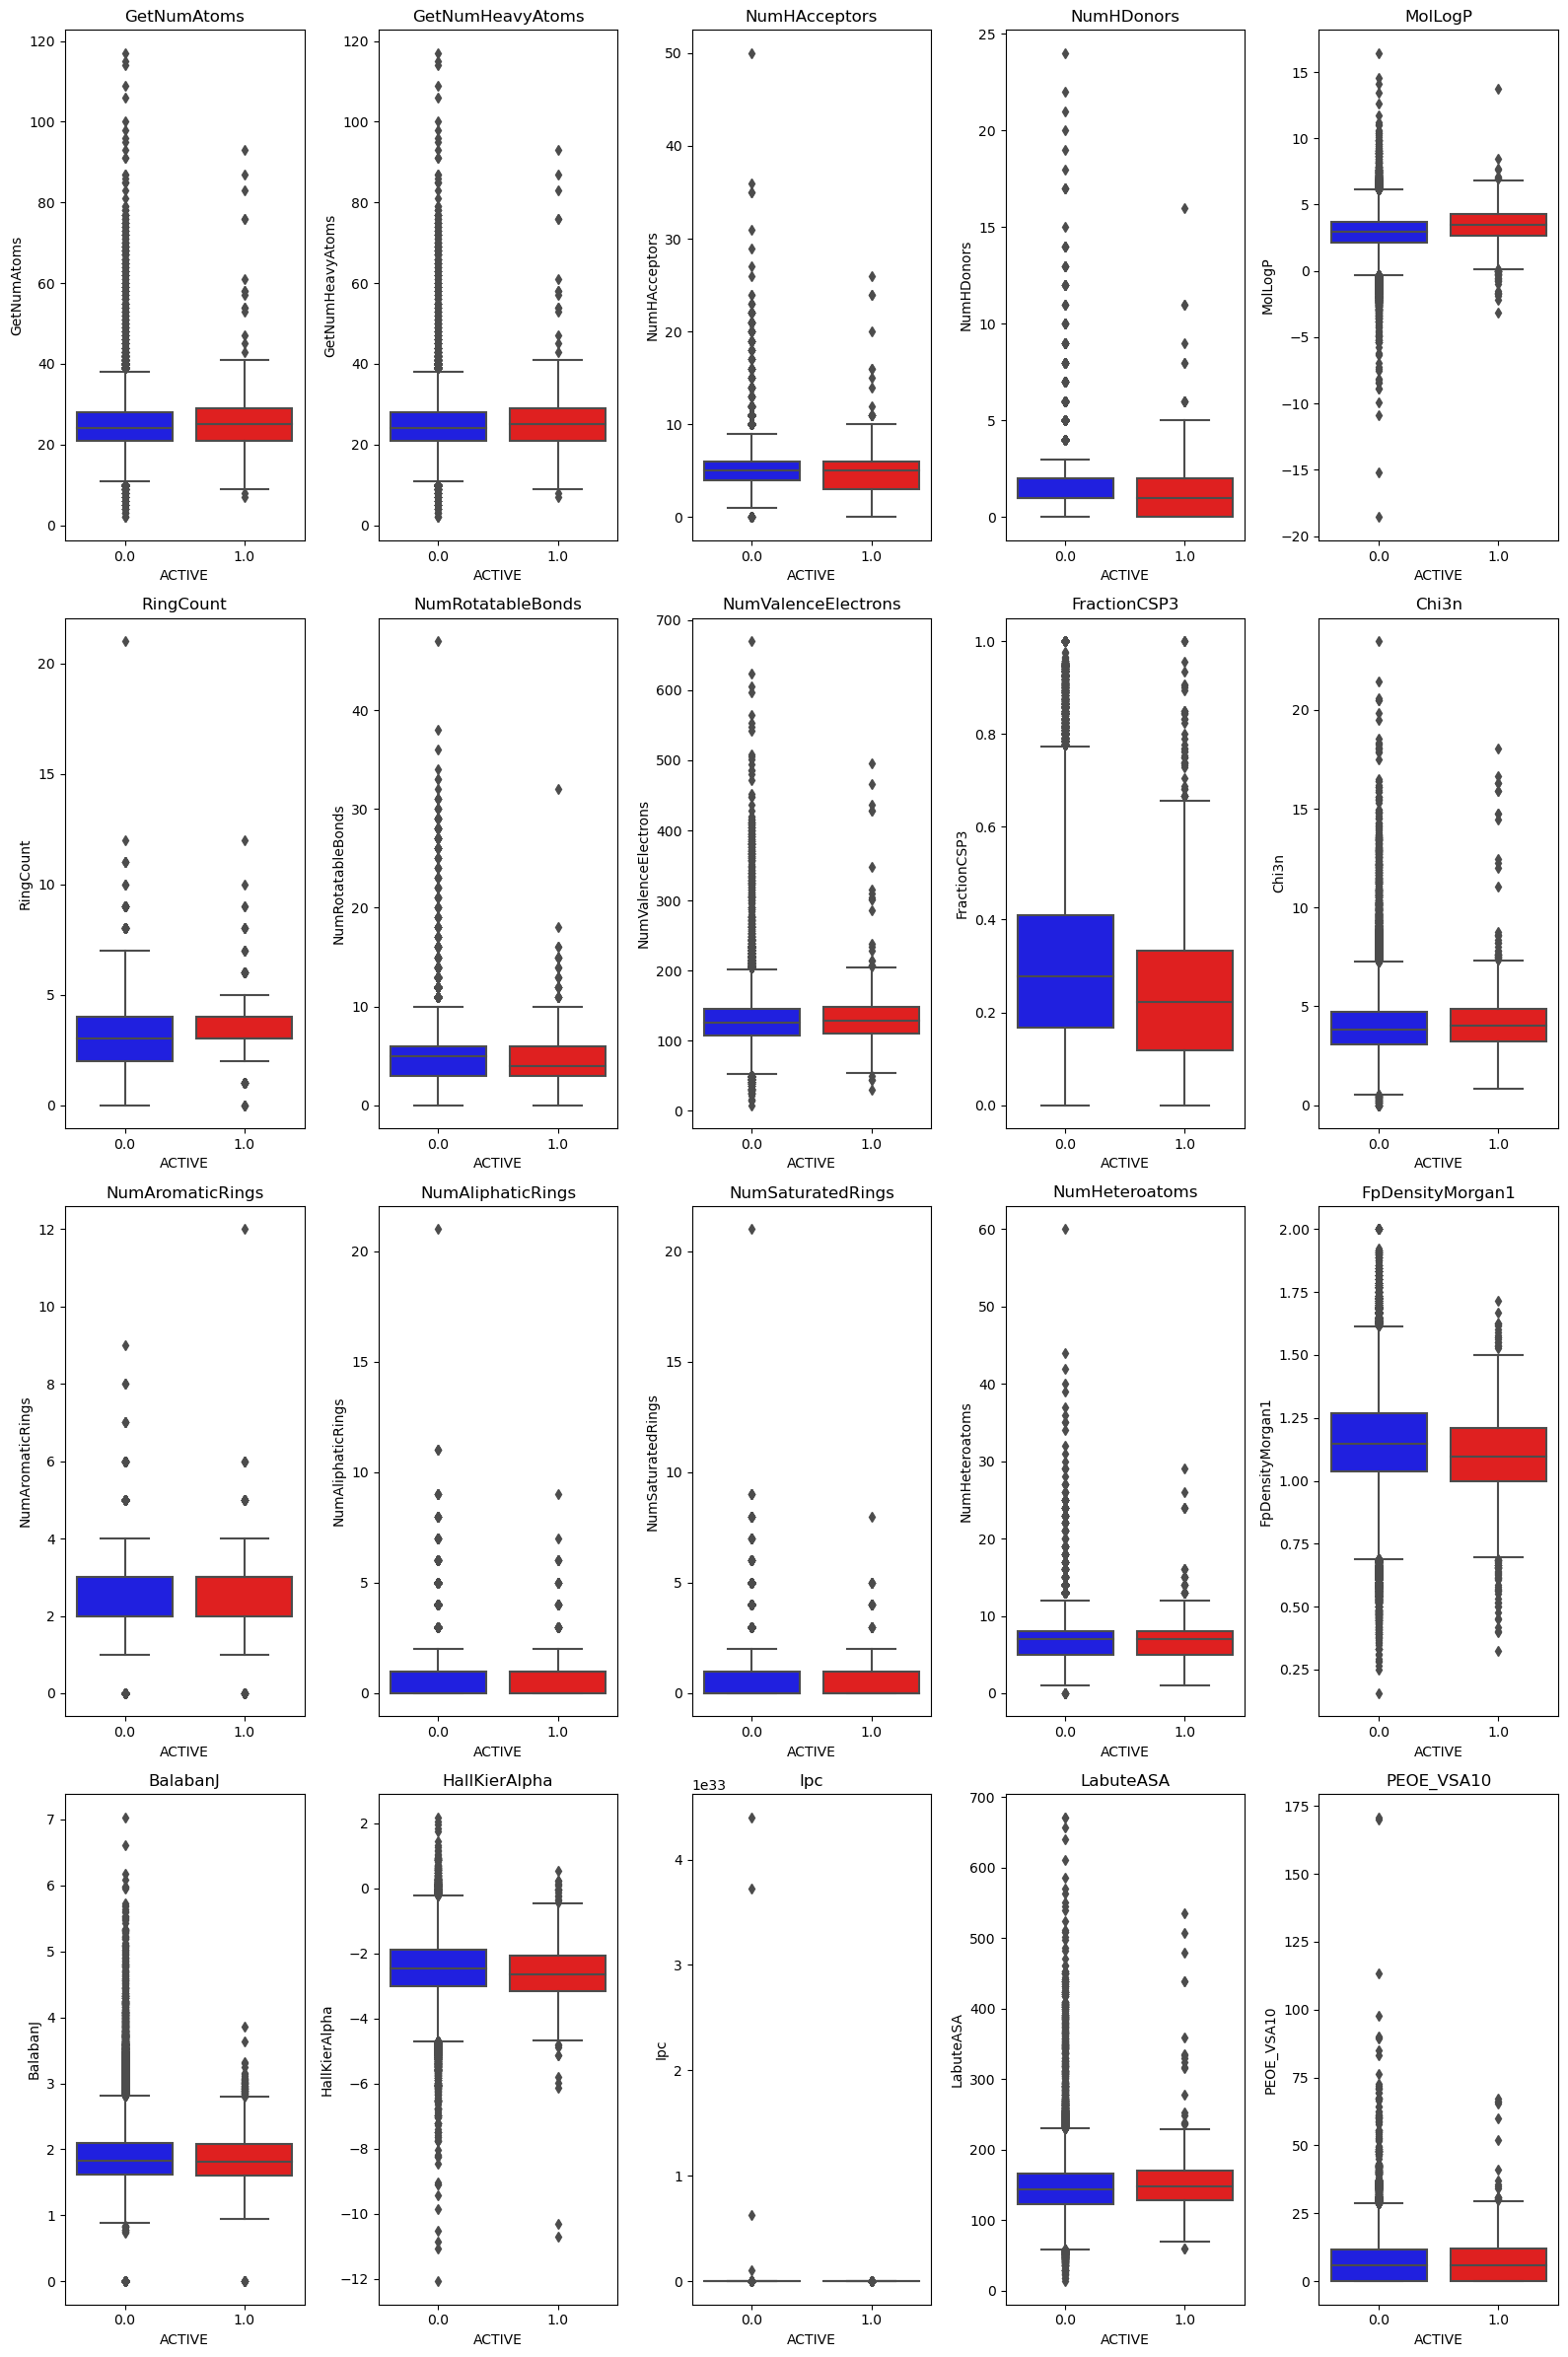

In [51]:
# Plotting kde plots
fig, ax = plt.subplots(4, 5, figsize=(16, 6*4))

cols = np.array(train_df.columns[2:-1]).reshape((4,5))

for i in range(4):
    for j in range(5):
        sns.boxplot(x='ACTIVE', y=cols[i,j], data=train_df, palette={0.0:'blue', 1.0:'red'}, ax=ax[i,j])
        ax[i,j].set_title(cols[i,j])

plt.tight_layout()

## **Data Preprocessing**

## **Model Selection**

## **Results**

## **Conclusions**